In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import skimage

from IPython import display
%matplotlib inline

tfk = tf.keras
tfkl = tf.keras.layers

/home/justinvyu/anaconda3/envs/vice/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/justinvyu/anaconda3/envs/vice/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/justinvyu/anaconda3/envs/vice/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/justinvyu/anaconda3/envs/vice/lib/pyt

# Load Data

In [ ]:
from softlearning.models.state_estimation import (
    get_dumped_pkl_data
)
# images_path = '/home/justinvyu/dev/softlearning-vice/goal_classifier/free_screw_state_estimator_data_invisible_claw/more_data.pkl'
# images_path = '/root/nfs/kun1/users/justinvyu/data/fixed_data.pkl'
# images_path = '/root/nfs/kun1/users/justinvyu/data/invisible_claw_antialiased_data.pkl'
images_path = '/root/nfs/kun1/users/justinvyu/data/fixed_data_with_states.pkl'

images, states = get_dumped_pkl_data(images_path)

In [ ]:
images.shape, states.shape

In [ ]:
with gzip.open('/root/nfs/kun1/users/justinvyu/data/fixed_data.pkl', 'rb') as f:
    fixed_data = pickle.load(f)

In [ ]:
fixed_data_with_states = {
    'pixels': fixed_data,
    'states': states
}
with gzip.open('/root/nfs/kun1/users/justinvyu/data/fixed_data_with_states.pkl', 'wb') as f:
    pickle.dump(fixed_data_with_states, f)

In [ ]:
images, states = fixed_data_with_states['pixels'], fixed_data_with_states['states']

In [2]:
import gzip
import pickle

# Load data
with gzip.open('/nfs/kun1/users/justinvyu/data/s_a_sprime_invisible_claw.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
states = data['states'].reshape((-1, 4))
images = data['pixels'].reshape((-1, 32, 32, 3))

# Train state estimator on top of the VAE outputs

In [4]:
# Define trained VAE encoder
def preprocess(x):
    return tf.image.convert_image_dtype(x, dtype=tf.float32)

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=(32, 32, 3)),
    tfkl.Lambda(preprocess),
    tfkl.Conv2D(filters=32,
                kernel_size=3,
                strides=2,
                padding="SAME"),
    tfkl.Conv2D(filters=2 * 32,
                kernel_size=3,
                strides=2,
                padding="SAME"),
    tfkl.Conv2D(filters=4 * 32,
                kernel_size=3,
                strides=2,
                padding="SAME"),
    tfkl.Conv2D(filters=8 * 32,
                kernel_size=3,
                strides=1,
                padding="SAME"),
    tfkl.Conv2D(filters=8 * 32,
                kernel_size=4,
                padding="VALID"),
    tfkl.Flatten()
])
encoder.summary()
encoder.load_weights('/home/justinvyu/dev/z2/slac_invisible_claw_screw_sequence_length_16/weights/encoder_weights.h5')
encoder.trainable = False

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 256)         1048832   
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [14]:
from softlearning.preprocessors.utils import get_vae_preprocessor
# encoder_weights_fn = '/root/softlearning/softlearning/models/vae_weights/invisible_claw_encoder_weights_4_final.h5'
# decoder_weights_fn = '/root/softlearning/softlearning/models/vae_weights/invisible_claw_decoder_weights_4_final.h5'

# encoder_weights_fn = '/root/softlearning/softlearning/models/vae_weights/invisible_claw_encoder_weights.h5'
# decoder_weights_fn = '/root/softlearning/softlearning/models/vae_weights/invisible_claw_decoder_weights.h5'

# vae_preprocessor_params = {
#     'type': 'VAEPreprocessor',
#     'kwargs': {
#         'encoder_path': encoder_weights_fn,
#         'decoder_path': decoder_weights_fn,
#         'trainable': True,
#         'image_shape': (32, 32, 3),
#         'latent_dim': 16,
#         'include_decoder': False,
#     }
# }

from softlearning.models.state_estimation import state_estimator_model
# state_estimator = state_estimator_model(
#     input_shape=(32, 32, 3),
#     preprocessor_params=vae_preprocessor_params)
state_estimator = state_estimator_model(
    input_shape=(32, 32, 3),
    num_hidden_units=512,
    num_hidden_layers=4,
    preprocessor=encoder)

In [15]:
state_estimator.summary()

Model: "state_estimator_preprocessor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256)               1437248   
_________________________________________________________________
feedforward_state_est (Pickl (None, 4)                 921604    
Total params: 2,358,852
Trainable params: 921,604
Non-trainable params: 1,437,248
_________________________________________________________________


In [ ]:
from softlearning.preprocessors.utils import get_vae_preprocessor
vae = get_vae_preprocessor(**vae_preprocessor_params['kwargs'])

In [ ]:
vae.encoder.summary(), vae.decoder.summary()

In [ ]:
split_data = np.split(images, 50)

In [ ]:
reconstructions = []
for batch in split_data:
    reconstructions.append(vae(batch))

In [ ]:
reconstruct = np.concatenate(reconstructions, axis=0)

In [ ]:
import skimage
reconstruct_int = skimage.util.img_as_ubyte(reconstruct)

In [ ]:
dump = {
    'pixels': reconstruct_int,
    'states': states
}
import gzip
import pickle
with gzip.open('/root/nfs/kun1/users/justinvyu/data/reconstructions_with_state', 'wb') as f:
    pickle.dump(dump, f)

In [16]:
# Compile
state_estimator.compile(optimizer=tf.keras.optimizers.Adam(3e-4), loss='mse')

In [17]:
N_EPOCHS = 10

history = state_estimator.fit(
    x=images,
    y=states,
    batch_size=256,
    epochs=N_EPOCHS,
    validation_split=0.1
)

Train on 540000 samples, validate on 60000 samples
Epoch 1/10
540000/540000 [==============================] - 14s 26us/sample - loss: 0.0176 - val_loss: 0.0051
Epoch 2/10
540000/540000 [==============================] - 14s 26us/sample - loss: 0.0041 - val_loss: 0.0038
Epoch 3/10
540000/540000 [==============================] - 14s 25us/sample - loss: 0.0035 - val_loss: 0.0033
Epoch 4/10
540000/540000 [==============================] - 14s 25us/sample - loss: 0.0033 - val_loss: 0.0031
Epoch 5/10
540000/540000 [==============================] - 14s 26us/sample - loss: 0.0032 - val_loss: 0.0033
Epoch 6/10
540000/540000 [==============================] - 14s 25us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 7/10
540000/540000 [==============================] - 14s 26us/sample - loss: 0.0031 - val_loss: 0.0030
Epoch 8/10
540000/540000 [==============================] - 14s 26us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 9/10
540000/540000 [==============================] - 14s 26us/

# Show estimation errors

In [18]:
# Get samples to calculate metrics on
random_indices = np.random.choice(images.shape[0], size=10000)
test_images = images[random_indices]
test_labels = states[random_indices]
preds = state_estimator.predict(test_images)

In [21]:
pos_errors = []
angle_errors = []

degrees = lambda x: x * 180 / np.pi
def angle_distance(deg1, deg2):
    phi = np.abs(deg1 - deg2) % 360
    distance = 360 - phi if phi > 180 else phi
    return distance

for i, (test_img, label, pred) in enumerate(zip(test_images, test_labels, preds)):
    pos_error_xy = np.abs(label[:2] - pred[:2])
    pos_error = np.linalg.norm(pos_error_xy)
    pos_error = 15 * pos_error # free box is 30 cm, 15 on each side (-1 -> 1 --> -15 -> 15)
    
    true_angle = np.arctan2(label[3], label[2])
    true_angle = degrees(true_angle)
    pred_angle = np.arctan2(pred[3], pred[2])
    pred_angle = degrees(pred_angle)
    
    angle_error = angle_distance(true_angle, pred_angle)

    pos_errors.append(pos_error)
    angle_errors.append(angle_error)

mean_pos_error = np.mean(pos_errors)
mean_angle_error = np.mean(angle_errors)
print('MEAN POS ERROR (CM):', mean_pos_error)
print('MEAN ANGLE ERROR (degrees):', mean_angle_error)

MEAN POS ERROR (CM): 0.6729691349261525
MEAN ANGLE ERROR (degrees): 3.3941320892252334


In [ ]:
def display_top_errors(errors, label_str=""):
    errors = np.array(errors)
    ind = np.argpartition(errors, -20)[-20:]
    ind = ind[np.argsort(errors[ind])]
    ind = np.flip(ind) # Order descending
    print(ind)
    top_errors = errors[ind]
    
    top_error_imgs, top_error_labels, top_error_preds = test_images[ind], test_labels[ind], preds[ind]
    for i, (error, img, label, pred) in enumerate(zip(top_errors,
                                                      top_error_imgs,
                                                      top_error_labels,
                                                      top_error_preds)):
        print('\n========== IMAGE #', i, '=========')
        plt.axis('off')
        plt.imshow(img)
        print('{} ERROR: {}\n\ntrue: {}\npred: {}'.format(label_str, error, label, pred))
        plt.show()

In [ ]:
display_top_errors(pos_errors, label_str="POS (cm)")
display_top_errors(angle_errors, label_str="ANGLE (degrees)")

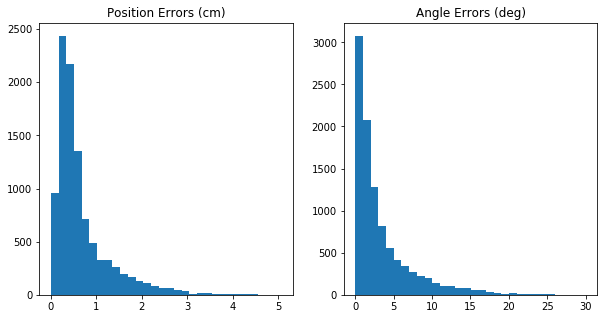

In [22]:
def plot_histograms(pos_errors, angle_errors):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Position Errors (cm)')
    plt.hist(pos_errors, bins=30)
    plt.subplot(1, 2, 2)
    plt.title('Angle Errors (deg)')
    plt.hist(angle_errors, bins=30)
    plt.show()
    
plot_histograms(pos_errors, angle_errors)

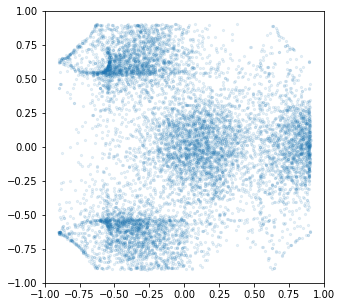

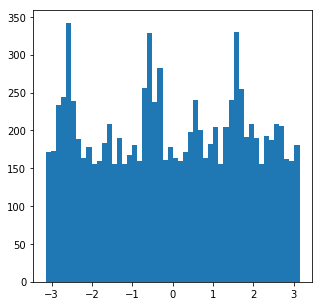

In [23]:
def plot_pos_support():
    plt.figure(figsize=(5, 5))
    plt.scatter(test_labels[:, 0], test_labels[:, 1], alpha=0.1, s=5)
    plt.show()
    
plot_pos_support()

def plot_angle_support():
    plt.figure(figsize=(5,5))
    angles = np.arctan2(test_labels[:, 3], test_labels[:, 2])
    plt.hist(angles, bins=50)
    plt.show()
    
plot_angle_support()

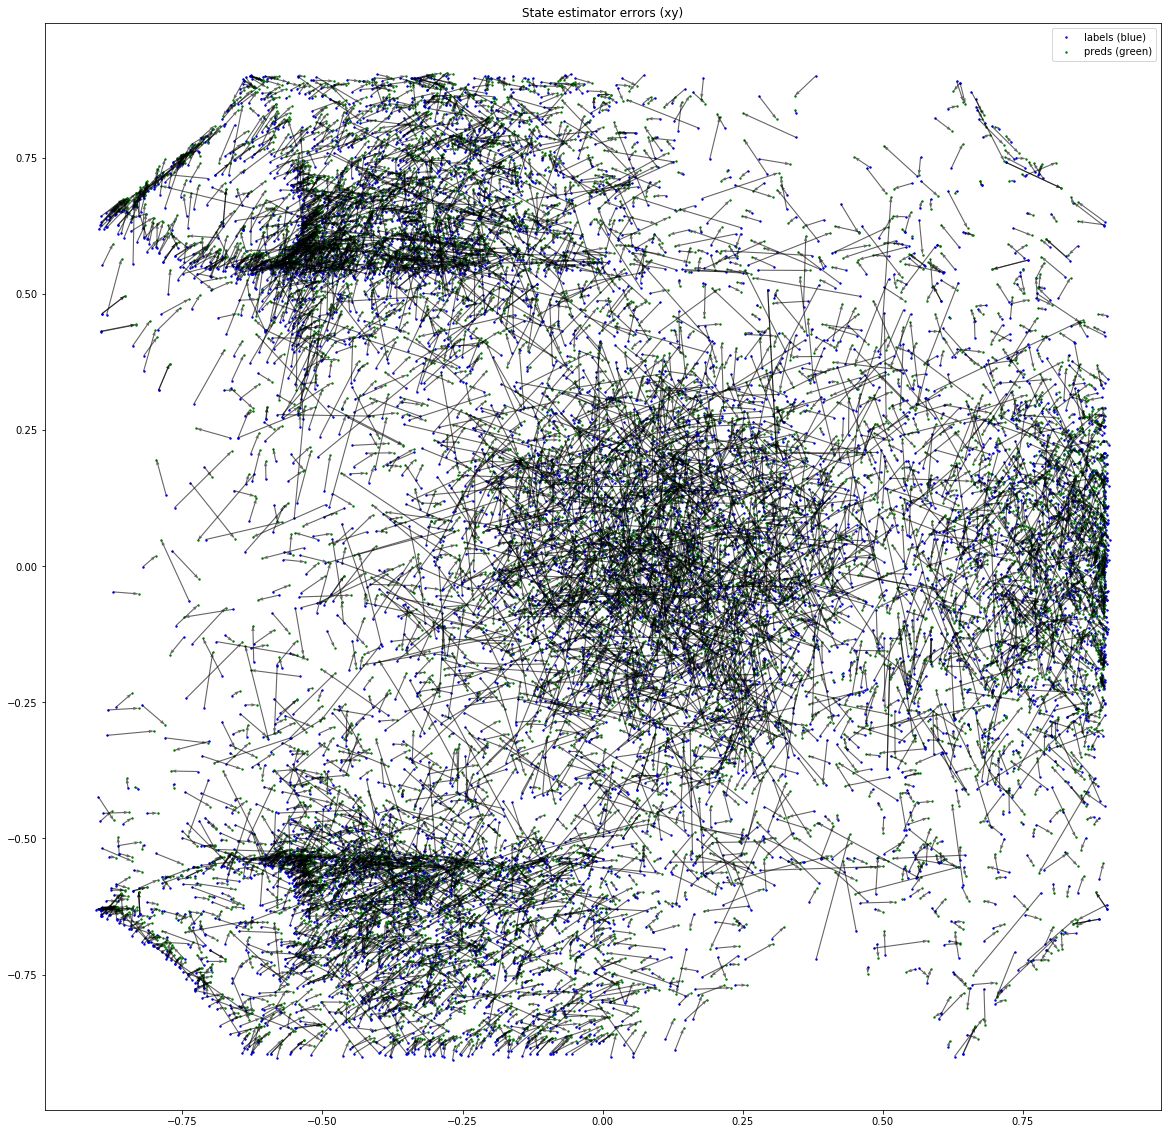

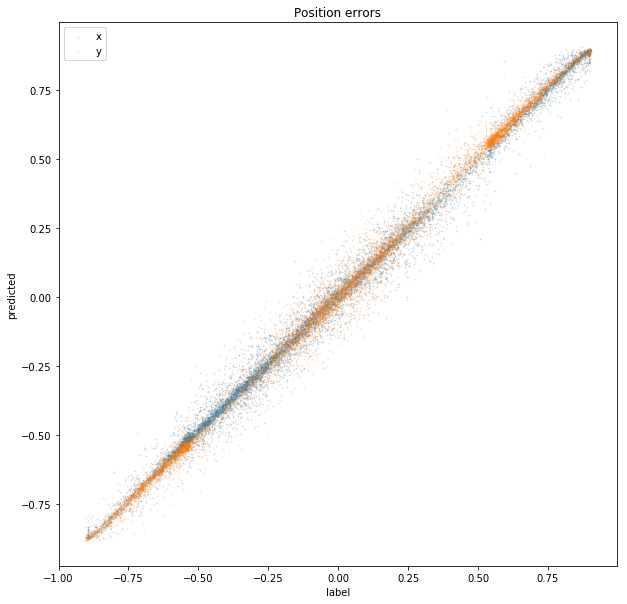

In [19]:
def get_noise(size, loc=0, scale=0.02):
    return np.random.normal(loc=loc, scale=scale, size=size)

labels_x, labels_y = test_labels[:, 0], test_labels[:, 1]

preds_x, preds_y = preds[:, 0], preds[:, 1]
dxs, dys = preds_x - labels_x, preds_y - labels_y
plt.figure(figsize=(20, 20))
plt.title('State estimator errors (xy)')

plt.scatter(labels_x, labels_y, c='blue', s=2, label='labels (blue)')
plt.scatter(preds_x, preds_y, c='green', s=2, label='preds (green)')
plt.legend()
plt.quiver(labels_x, labels_y, dxs, dys, angles='xy', scale_units='xy', scale=1, width=0.001, alpha=0.6)

plt.figure(figsize=(10, 10))
plt.title('Position errors')
plt.xlabel('label')
plt.ylabel('predicted')

plt.scatter(labels_x, preds_x, s=0.5, alpha=0.2, label='x')
plt.scatter(labels_y, preds_y, s=0.5, alpha=0.2, label='y')
plt.legend()

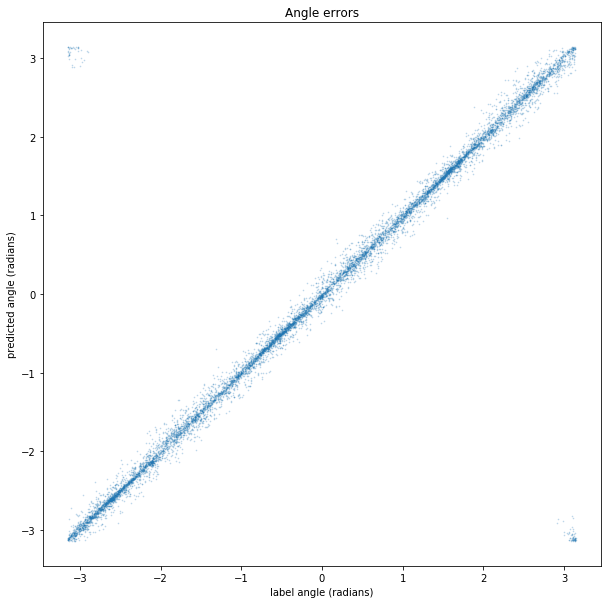

In [12]:
labels_z_cos, labels_z_sin = test_labels[:, 2], test_labels[:, 3]
preds_z_cos, preds_z_sin = preds[:, 2], preds[:, 3]
dzs_cos, dzs_sin = preds_z_cos - labels_z_cos, preds_z_sin - labels_z_sin

labels_angle, preds_angle = (
    np.arctan2(labels_z_sin, labels_z_cos),
    np.arctan2(preds_z_sin, preds_z_cos)
)
plt.figure(figsize=(10, 10))
plt.title('Angle errors')
plt.xlabel('label angle (radians)')
plt.ylabel('predicted angle (radians)')
plt.scatter(labels_angle, preds_angle, s=0.4, alpha=0.25)

In [ ]:
vae = state_estimator.get_layer('vae_preprocessor')
vae(test_images[0][None])